This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler   # 做特征标准化

# 如果本地没有 utils.py，这行会报错，我们新的流程也不再用 climbench 的 utils，
# 所以可以删掉 / 注释掉：
# from utils import *

# jupyter 画图设置，保持不变
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams['legend.frameon'] = False


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()

# 你的 nc 文件所在的文件夹，例如和 notebook 同一目录就写 "."
data_dir = cwd   # 或者 r"D:\your\path\to\nc_files"


### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [4]:
import os
os.listdir()


['.ipynb_checkpoints',
 'Final Proj.ipynb',
 'utils.py',
 '__pycache__',
 'wind.ipynb',
 'salinity.ipynb',
 'SST.ipynb',
 'pCO2_TropicalPacific_1980_2020.nc',
 'CNN_Final_Proj.ipynb',
 'SST_TropicalPacific_1980_2020.nc',
 'unify_latlon.py',
 'Untitled.ipynb',
 '.nc',
 'fgco2_TropicalPacific_1980_2020.nc',
 'ERA5_TropicalPacific_WindSpeed_1980_2020.nc',
 'saved_model',
 'cnn_flux_residuals.nc',
 'cnn_flux_global_metrics.csv',
 'cnn_flux_rmse_bias_maps.nc',
 'cnn_flux_single_vs_allvars_metrics.csv']

In [5]:
def unify_latlon(ds):
    """把经纬度维度统一成 lat / lon，其他维度保持不变。"""
    rename_dict = {}
    if 'latitude' in ds.dims:
        rename_dict['latitude'] = 'lat'
    if 'Latitude' in ds.dims:
        rename_dict['Latitude'] = 'lat'
    if 'longitude' in ds.dims:
        rename_dict['longitude'] = 'lon'
    if 'Longitude' in ds.dims:
        rename_dict['Longitude'] = 'lon'
    if rename_dict:
        ds = ds.rename(rename_dict)
    return ds

In [6]:
import xarray as xr
import os

wind_path = os.path.join(data_dir, "ERA5_TropicalPacific_WindSpeed_1980_2020.nc")

wind_ds = xr.open_dataset(wind_path)

print(wind_ds)


<xarray.Dataset> Size: 539MB
Dimensions:     (time: 468, latitude: 189, longitude: 761)
Coordinates:
  * time        (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2018-12-01
  * latitude    (latitude) float32 756B 23.5 23.25 23.0 ... -23.0 -23.25 -23.5
  * longitude   (longitude) float32 3kB 100.0 100.2 100.5 ... 289.5 289.8 290.0
Data variables:
    wind_speed  (time, latitude, longitude) float64 538MB ...


getfattr: /home/jovyan/Final: No such file or directory
getfattr: Proj/ERA5_TropicalPacific_WindSpeed_1980_2020.nc: No such file or directory


In [7]:
import pandas as pd

# 1. 读 nc 数据
flux_ds  = xr.open_dataset(os.path.join(data_dir, "fgco2_TropicalPacific_1980_2020.nc"))
sst_ds   = xr.open_dataset(os.path.join(data_dir, "SST_TropicalPacific_1980_2020.nc"))      # 如有 (1) 记得改名
wind_ds  = xr.open_dataset(os.path.join(data_dir, "ERA5_TropicalPacific_WindSpeed_1980_2020.nc"))
pco2_ds  = xr.open_dataset(os.path.join(data_dir, "pCO2_TropicalPacific_1980_2020.nc"))
wind_path = os.path.join(data_dir, "ERA5_TropicalPacific_WindSpeed_1980_2020.nc")  # or *_2018.nc
print("wind_path =", wind_path)
print("wind_ds is flux_ds ? -->", wind_ds is flux_ds)
# print(wind_ds)
print(flux_ds)   # 看 data variables
print(wind_ds)   # 再看 data variables

# 2. 统一经纬度维度名为 lat / lon
flux_ds = unify_latlon(flux_ds)
sst_ds  = unify_latlon(sst_ds)
wind_ds = unify_latlon(wind_ds)
pco2_ds = unify_latlon(pco2_ds)

print("flux dims:", flux_ds.dims)
print("sst  dims:", sst_ds.dims)
print("wind dims:", wind_ds.dims)
print("pco2 dims:", pco2_ds.dims)
print("wind_ds =")
print(wind_ds)

# 3. 看一下各自的时间范围
for name, ds in [("flux", flux_ds),
                 ("sst",  sst_ds),
                 ("wind", wind_ds),
                 ("pco2", pco2_ds)]:
    t = ds["time"]
    print(name, "time range:", str(t.values[0]), "→", str(t.values[-1]), "| n =", t.size)

# 4. 计算 ΔpCO2 = pco2_sea - pco2_air
pco2_ocean = pco2_ds["pco2_sea"]   # (time, lat, lon)
pco2_atm   = pco2_ds["pco2_air"]
dpco2_full = pco2_ocean - pco2_atm

# 5. ERA5 风速按月平均成月度数据
wind_raw = wind_ds["wind_speed"]      # (time, lat, lon)
wind_mon = wind_raw.resample(time="MS").mean()

print("wind_mon time range:", str(wind_mon.time.values[0]), "→",
      str(wind_mon.time.values[-1]), "| n =", wind_mon.time.size)

# 6. 统一时间轴：以 wind_mon 的月度时间为基准（到 2018-12）
time_common = wind_mon["time"].sel(time=slice("1980-01-01", "2018-12-01"))
n_time = time_common.size
years  = pd.DatetimeIndex(time_common.values).year.values

print("统一时间步数:", n_time)
print("统一时间范围:", time_common.values[0], "→", time_common.values[-1])

# 7. 在统一时间轴上对齐四个变量：
#    flux/sst/pco2 是每月 15/16 号，wind_mon 是每月 1 号，用最近时间匹配 method='nearest'
flux_map  = flux_ds["fgco2"].sel(time=time_common, method="nearest")     # (T, lat, lon)
sst_map   = sst_ds["sst"].sel(time=time_common, method="nearest")
dpco2_map = dpco2_full.sel(time=time_common, method="nearest")
wind_map  = wind_mon.sel(time=time_common)                               # 已经是 MS，不用 nearest

# 8. 空间平均，得到 3 个输入时间序列（只在 lat/lon 上平均）
dpco2_ts = dpco2_map.mean(dim=("lat", "lon"), skipna=True).values.reshape(n_time, 1)
sst_ts   = sst_map.mean(   dim=("lat", "lon"), skipna=True).values.reshape(n_time, 1)
wind_ts  = wind_map.mean(  dim=("lat", "lon"), skipna=True).values.reshape(n_time, 1)

print("dpco2_ts any NaN?", np.isnan(dpco2_ts).any())
print("sst_ts   any NaN?", np.isnan(sst_ts).any())
print("wind_ts  any NaN?", np.isnan(wind_ts).any())


# 如果 wind_ts 还有 NaN，用整体均值把 NaN 填掉
if np.isnan(wind_ts).any():
    wind_mean = np.nanmean(wind_ts)
    wind_ts   = np.nan_to_num(wind_ts, nan=wind_mean)

print("wind_ts any NaN after fill?", np.isnan(wind_ts).any())

print("dpco2_ts shape:", dpco2_ts.shape)
print("sst_ts   shape:", sst_ts.shape)
print("wind_ts  shape:", wind_ts.shape)

# 9. 输出通量保留为地图 (T, lat, lon)
flux_all = flux_map.values
print("flux_all shape:", flux_all.shape)
print("years range:", years.min(), "→", years.max(), "len =", len(years))

# 10. 把三个输入拼成 X_all: (n_time, 3)
X_all   = np.concatenate([dpco2_ts, sst_ts, wind_ts], axis=1)
time_all = time_common.values

print("X_all shape:", X_all.shape)

# 11. 按年份划分 train / val / test
train_mask = (years >= 1980) & (years <= 2010)
val_mask   = (years >= 2011) & (years <= 2015)
test_mask  = (years >= 2016) & (years <= 2018)

X_train = X_all[train_mask]
X_val   = X_all[val_mask]
X_test  = X_all[test_mask]

y_train = flux_all[train_mask]
y_val   = flux_all[val_mask]
y_test  = flux_all[test_mask]

time_train = time_all[train_mask]
time_val   = time_all[val_mask]
time_test  = time_all[test_mask]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:",   X_val.shape,   "y_val:",   y_val.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)


getfattr: /home/jovyan/Final: No such file or directory
getfattr: Proj/fgco2_TropicalPacific_1980_2020.nc: No such file or directory
getfattr: /home/jovyan/Final: No such file or directory
getfattr: Proj/SST_TropicalPacific_1980_2020.nc: No such file or directory
getfattr: /home/jovyan/Final: No such file or directory
getfattr: Proj/ERA5_TropicalPacific_WindSpeed_1980_2020.nc: No such file or directory
getfattr: /home/jovyan/Final: No such file or directory
getfattr: Proj/pCO2_TropicalPacific_1980_2020.nc: No such file or directory


wind_path = /home/jovyan/Final Proj/ERA5_TropicalPacific_WindSpeed_1980_2020.nc
wind_ds is flux_ds ? --> False
<xarray.Dataset> Size: 38MB
Dimensions:  (time: 492, lat: 48, lon: 200)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-15 1980-02-15 ... 2020-12-15
  * lat      (lat) float64 384B -23.5 -22.5 -21.5 -20.5 ... 20.5 21.5 22.5 23.5
  * lon      (lon) float64 2kB 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
Data variables:
    fgco2    (time, lat, lon) float64 38MB ...
Attributes:
    description:  Tropical Pacific (100E–280E, 23.5S–23.5N), monthly fgco2, 1...
    source:       Derived from LDEO-HPD v2023 (Lamont-Doherty Earth Observatory)
    units:        mol/m²/yr (or dataset default)
<xarray.Dataset> Size: 539MB
Dimensions:     (time: 468, latitude: 189, longitude: 761)
Coordinates:
  * time        (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2018-12-01
  * latitude    (latitude) float32 756B 23.5 23.25 23.0 ... -23.0 -23.25 -23.5
  * longitude   (longitude

#### select relevant variables

predictors: ΔpCO₂, SST, wind speed
predictand: CO₂ flux (2-D map)

In [8]:
# 把 3 个输入变量做成 DataFrame（主要是方便之后查看，训练时我们会转回 numpy/torch）
X_train_df = pd.DataFrame(
    {
        "dpco2": X_train[:, 0],   # ΔpCO2
        "sst":   X_train[:, 1],   # 海表温度
        "wind":  X_train[:, 2],   # 风速
    },
    index=time_train
)

X_test_df = pd.DataFrame(
    {
        "dpco2": X_test[:, 0],
        "sst":   X_test[:, 1],
        "wind":  X_test[:, 2],
    },
    index=time_test
)

# y_train / y_test 已经在上一格是 flux 地图数组了，直接沿用
# y_train.shape = (n_train, n_lat, n_lon)
# y_test.shape  = (n_test,  n_lat, n_lon)
print("X_train_df columns:", X_train_df.columns)
print("y_train shape:", y_train.shape)


X_train_df columns: Index(['dpco2', 'sst', 'wind'], dtype='object')
y_train shape: (372, 48, 200)


This is how our predictors & predictand data look like. Our predictors are **1-D** time series of CO2 & CH4.

In [9]:
X_train_df.head()

,dpco2,sst,wind
1980-01-01,13.710226,26.860521,5.577335
1980-02-01,13.955562,26.905903,5.597297
1980-03-01,16.240332,26.905903,5.732871
1980-04-01,14.203870,27.299591,5.617886
1980-05-01,12.349929,27.299591,5.651157


The predictand CO₂ flux is a 2-D map. - this point is different from the NN case

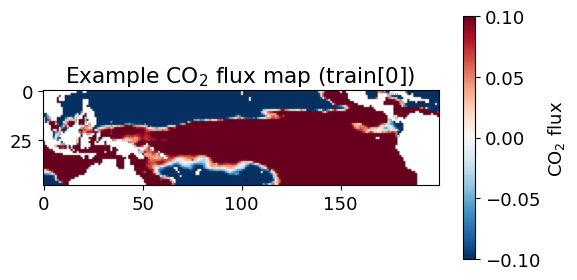

In [10]:
# 看第一帧的 CO2 通量地图
fig, ax = plt.subplots(figsize=(6, 3))

im = ax.imshow(
    np.flip(y_train[0], axis=0),   # 如果你之前画风速 / pCO2 也是这么 flip，就保持
    cmap='RdBu_r',
    # 用百分位自动定 vmin/vmax，比写死 -3,3 更安全
    vmin=np.percentile(y_train[0], 5),
    vmax=np.percentile(y_train[0], 95)
)
plt.colorbar(im, ax=ax, label='CO$_2$ flux')

ax.set_title("Example CO$_2$ flux map (train[0])")
plt.tight_layout()
plt.show()


#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [11]:
# ===== 1. 先把 X 做成 DataFrame =====
# （这里假设你已经有 X_train / X_val / X_test 的 numpy 数组，
#   如果你是直接用 column_stack 得到 X_all 再切 train/val/test，和我们之前写的是一致的）

X_train_df = pd.DataFrame(
    {
        "dpco2": X_train[:, 0],
        "sst":   X_train[:, 1],
        "wind":  X_train[:, 2],
    },
    index=time_train,
)
X_val_df = pd.DataFrame(
    {
        "dpco2": X_val[:, 0],
        "sst":   X_val[:, 1],
        "wind":  X_val[:, 2],
    },
    index=time_val,
)
X_test_df = pd.DataFrame(
    {
        "dpco2": X_test[:, 0],
        "sst":   X_test[:, 1],
        "wind":  X_test[:, 2],
    },
    index=time_test,
)

# ===== 2. 先用训练集均值填补 NaN，然后做标准化 =====
# 用训练集的 mean 填补所有 NaN
X_train_df = X_train_df.fillna(X_train_df.mean())
X_val_df   = X_val_df.fillna(X_train_df.mean())
X_test_df  = X_test_df.fillna(X_train_df.mean())

# 标准化
mean = X_train_df.mean()
std  = X_train_df.std()

# 防止 std 为 0
std_safe = std.replace(0, 1.0)

X_train_df = (X_train_df - mean) / std_safe
X_val_df   = (X_val_df   - mean) / std_safe
X_test_df  = (X_test_df  - mean) / std_safe

# 转成 numpy，并再做一次兜底，确保没有 NaN/Inf
X_train_np = X_train_df.to_numpy().astype("float32")
X_val_np   = X_val_df.to_numpy().astype("float32")
X_test_np  = X_test_df.to_numpy().astype("float32")

X_train_np = np.nan_to_num(X_train_np, nan=0.0, posinf=0.0, neginf=0.0)
X_val_np   = np.nan_to_num(X_val_np,   nan=0.0, posinf=0.0, neginf=0.0)
X_test_np  = np.nan_to_num(X_test_np,  nan=0.0, posinf=0.0, neginf=0.0)

print("X_train_np any NaN?", np.isnan(X_train_np).any())
print("X_val_np   any NaN?", np.isnan(X_val_np).any())
print("X_test_np  any NaN?", np.isnan(X_test_np).any())

# ===== 3. 处理 y 里的 NaN，再转 tensor =====
y_train = np.nan_to_num(y_train, nan=0.0)
y_val   = np.nan_to_num(y_val,   nan=0.0)
y_test  = np.nan_to_num(y_test,  nan=0.0)

print("y_train any NaN?", np.isnan(y_train).any())
print("y_val   any NaN?", np.isnan(y_val).any())
print("y_test  any NaN?", np.isnan(y_test).any())

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

# ===== 4. X 也转成 tensor =====
X_train_tensor = torch.from_numpy(X_train_np)   # (N_train, 3)
X_val_tensor   = torch.from_numpy(X_val_np)
X_test_tensor  = torch.from_numpy(X_test_np)

# ===== 5. 构造 Dataset =====
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = torch.utils.data.TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = torch.utils.data.TensorDataset(X_test_tensor,  y_test_tensor)


X_train_np any NaN? False
X_val_np   any NaN? False
X_test_np  any NaN? False
y_train any NaN? False
y_val   any NaN? False
y_test  any NaN? False


In [12]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train loader batches:", len(train_loader))
print("Val   loader batches:", len(val_loader))
print("Test  loader batches:", len(test_loader))


Train loader batches: 12
Val   loader batches: 2
Test  loader batches: 2


In [13]:
print("X_train_np shape:", X_train_np.shape)
print("X_val_np   shape:", X_val_np.shape)
print("X_test_np  shape:", X_test_np.shape)

print("y_train_tensor shape:", y_train_tensor.shape)
print("y_val_tensor   shape:", y_val_tensor.shape)
print("y_test_tensor  shape:", y_test_tensor.shape)


X_train_np shape: (372, 3)
X_val_np   shape: (60, 3)
X_test_np  shape: (36, 3)
y_train_tensor shape: torch.Size([372, 1, 48, 200])
y_val_tensor   shape: torch.Size([60, 1, 48, 200])
y_test_tensor  shape: torch.Size([36, 1, 48, 200])


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [14]:
n_filters     = 32     # 卷积层的通道数
n_neurons     = 32     # 这个模板其实没用到，可以先保留
activation    = 'ReLU' # 激活函数
kernel_size   = 4
learning_rate = 1e-3
minibatch_size = 32    # 建议和 DataLoader 里的 batch_size 一致
num_epochs    = 100


In [15]:
def make_CNN_model(input_dim, n_filters, activation, kernel_size):
    layers = []

    # 1. 先用全连接层把 3 维输入映射到一个小 feature map
    #    这里选 base_grid = (12, 50)，最后通过两次上采样变成 48x200
    base_H, base_W = 12, 50
    layers.append(nn.Linear(input_dim, n_filters * base_H * base_W))
    layers.append(getattr(nn, activation)())

    # 2. 自定义 Reshape，把 (batch, n_filters*H*W) 变成 (batch, n_filters, H, W)
    class Reshape(nn.Module):
        def __init__(self, shape):
            super().__init__()
            self.shape = shape  # (C, H, W)

        def forward(self, x):
            # x: (batch, C*H*W) -> (batch, C, H, W)
            return x.view(-1, *self.shape)

    # PyTorch 卷积采用 (N, C, H, W)
    layers.append(Reshape((n_filters, base_H, base_W)))  # (B, 32, 12, 50)

    # 3. 第一次上采样: 12x50 -> 24x100
    layers.append(
        nn.ConvTranspose2d(
            n_filters, n_filters,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
    )
    layers.append(getattr(nn, activation)())             # (B, 32, 24, 100)

    # 4. 第二次上采样: 24x100 -> 48x200
    layers.append(
        nn.ConvTranspose2d(
            n_filters, n_filters,
            kernel_size=kernel_size,
            stride=2,
            padding=1
        )
    )
    layers.append(getattr(nn, activation)())             # (B, 32, 48, 200)

    # 5. 输出层: 32 通道 -> 1 通道，大小保持 48x200
    layers.append(
        nn.Conv2d(
            n_filters, 1,
            kernel_size=3,
            padding=1
        )
    )  # 输出形状: (B, 1, 48, 200)

    return nn.Sequential(*layers)


In [16]:
input_dim = 3
model = make_CNN_model(input_dim, n_filters, activation, kernel_size).to(device)

dummy_x = torch.randn(4, input_dim).to(device)   # 假的 4 个样本
dummy_y = model(dummy_x)
print("dummy_y shape:", dummy_y.shape)


dummy_y shape: torch.Size([4, 1, 48, 200])


In [17]:
model_mse = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

print("Model:")
print(model_mse)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mse.parameters())}")


Model:
Sequential(
  (0): Linear(in_features=3, out_features=19200, bias=True)
  (1): ReLU()
  (2): Reshape()
  (3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Total parameters: 109921


In [18]:
# 这里 input_dim = 3，对应 dpco2 / sst / wind 三个变量
input_dim = X_train_tensor.shape[1]   # 或者 X_train_np.shape[1] 也可以

model_mse = make_CNN_model(input_dim, n_filters, activation, kernel_size).to(device)

print("Model:")
print(model_mse)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mse.parameters())}")


Model:
Sequential(
  (0): Linear(in_features=3, out_features=19200, bias=True)
  (1): ReLU()
  (2): Reshape()
  (3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Total parameters: 109921


### 3. Train & save the CNN model

In [19]:
def pytorch_train(
    model,
    optimizer,
    criterion,
    device,
    train_loader,
    val_loader,
    num_epochs,
    patience=20,
):
    model.to(device)

    best_val_loss = float("inf")
    best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    patience_counter = 0

    train_losses = []
    val_losses   = []

    for epoch in range(num_epochs):
        # ----- training -----
        model.train()
        train_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # ----- validation -----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
        )

        # 如果 loss 不是有限值（NaN/Inf），就直接停止，避免再训练下去
        if not np.isfinite(val_loss):
            print("Val loss is not finite (NaN/Inf), stopping training.")
            break

        # ----- early stopping -----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # 恢复到验证集最优的那一版参数
    model.load_state_dict(best_state_dict)
    model.to(device)

    return train_losses, val_losses


In [20]:
# Create data loaders for batched training
batch_size = minibatch_size   # 或者直接写 batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

print("Train batches:", len(train_loader))
print("Val   batches:", len(val_loader))
print("Test  batches:", len(test_loader))


Train batches: 12
Val   batches: 2
Test  batches: 2


In [21]:
print("X_train_np any NaN? ", np.isnan(X_train_np).any())
print("X_val_np   any NaN? ", np.isnan(X_val_np).any())
print("X_test_np  any NaN? ", np.isnan(X_test_np).any())

print("y_train any NaN? ", np.isnan(y_train).any())
print("y_val   any NaN? ", np.isnan(y_val).any())
print("y_test  any NaN? ", np.isnan(y_test).any())

print("y_train min / max (ignoring NaN):",
      np.nanmin(y_train), np.nanmax(y_train))


X_train_np any NaN?  False
X_val_np   any NaN?  False
X_test_np  any NaN?  False
y_train any NaN?  False
y_val   any NaN?  False
y_test  any NaN?  False
y_train min / max (ignoring NaN): -4.980700572783663 34.63321821601089


In [22]:
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=learning_rate)

# Loss function
mse_loss = nn.MSELoss()


In [23]:
# 先把 y 里的 NaN 处理掉（这里示范直接填 0，你也可以用 mean）
y_train_clean = np.nan_to_num(y_train, nan=0.0)
y_val_clean   = np.nan_to_num(y_val,   nan=0.0)
y_test_clean  = np.nan_to_num(y_test,  nan=0.0)

# 如果你更想填均值，可以这样：
# y_train_clean = np.where(np.isnan(y_train), np.nanmean(y_train), y_train)
# y_val_clean   = np.where(np.isnan(y_val),   np.nanmean(y_val),   y_val)
# y_test_clean  = np.where(np.isnan(y_test),  np.nanmean(y_test),  y_test)


In [24]:
train_losses_mse, val_losses_mse = pytorch_train(
    model_mse,         # 不要再 .to(device)，函数内部已经会处理
    optimizer_mse,
    mse_loss,
    device,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    patience=20,
)


Epoch 1/100 | Train Loss: 1.2794 | Val Loss: 1.4480
Epoch 2/100 | Train Loss: 1.2163 | Val Loss: 1.4218
Epoch 3/100 | Train Loss: 1.1886 | Val Loss: 1.3822
Epoch 4/100 | Train Loss: 1.1416 | Val Loss: 1.3039
Epoch 5/100 | Train Loss: 1.0315 | Val Loss: 1.0778
Epoch 6/100 | Train Loss: 0.7949 | Val Loss: 0.8440
Epoch 7/100 | Train Loss: 0.6419 | Val Loss: 0.6756
Epoch 8/100 | Train Loss: 0.5542 | Val Loss: 0.6092
Epoch 9/100 | Train Loss: 0.5045 | Val Loss: 0.5609
Epoch 10/100 | Train Loss: 0.4622 | Val Loss: 0.5184
Epoch 11/100 | Train Loss: 0.4299 | Val Loss: 0.4803
Epoch 12/100 | Train Loss: 0.4029 | Val Loss: 0.4532
Epoch 13/100 | Train Loss: 0.3818 | Val Loss: 0.4397
Epoch 14/100 | Train Loss: 0.3682 | Val Loss: 0.4395
Epoch 15/100 | Train Loss: 0.3605 | Val Loss: 0.4156
Epoch 16/100 | Train Loss: 0.3499 | Val Loss: 0.3948
Epoch 17/100 | Train Loss: 0.3435 | Val Loss: 0.3960
Epoch 18/100 | Train Loss: 0.3373 | Val Loss: 0.3939
Epoch 19/100 | Train Loss: 0.3327 | Val Loss: 0.3873
Ep

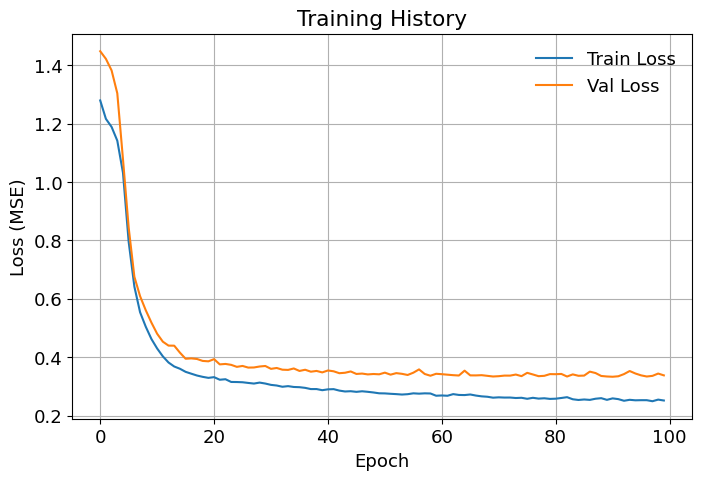

In [25]:
def plot_history(train_losses, val_losses):
    """
    绘制训练集和验证集 loss 曲线
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_history(train_losses_mse, val_losses_mse)

In [26]:
model_mae = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

# L1Loss = MAE
mae_loss = nn.L1Loss(reduction='mean')
optimizer_mae = torch.optim.Adam(model_mae.parameters(), lr=learning_rate)

# 注意：这里不要再 .to(device)，函数内部已经会处理
train_losses_mae, val_losses_mae = pytorch_train(
    model_mae,
    optimizer_mae,
    mae_loss,
    device,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    patience=20,
)


Epoch 1/100 | Train Loss: 0.6662 | Val Loss: 0.7329
Epoch 2/100 | Train Loss: 0.6496 | Val Loss: 0.7174
Epoch 3/100 | Train Loss: 0.6186 | Val Loss: 0.6745
Epoch 4/100 | Train Loss: 0.5741 | Val Loss: 0.6173
Epoch 5/100 | Train Loss: 0.5183 | Val Loss: 0.5510
Epoch 6/100 | Train Loss: 0.4672 | Val Loss: 0.5060
Epoch 7/100 | Train Loss: 0.4381 | Val Loss: 0.4759
Epoch 8/100 | Train Loss: 0.4179 | Val Loss: 0.4608
Epoch 9/100 | Train Loss: 0.4039 | Val Loss: 0.4501
Epoch 10/100 | Train Loss: 0.3936 | Val Loss: 0.4378
Epoch 11/100 | Train Loss: 0.3846 | Val Loss: 0.4305
Epoch 12/100 | Train Loss: 0.3801 | Val Loss: 0.4271
Epoch 13/100 | Train Loss: 0.3754 | Val Loss: 0.4190
Epoch 14/100 | Train Loss: 0.3722 | Val Loss: 0.4186
Epoch 15/100 | Train Loss: 0.3694 | Val Loss: 0.4127
Epoch 16/100 | Train Loss: 0.3674 | Val Loss: 0.4086
Epoch 17/100 | Train Loss: 0.3646 | Val Loss: 0.4090
Epoch 18/100 | Train Loss: 0.3601 | Val Loss: 0.4045
Epoch 19/100 | Train Loss: 0.3607 | Val Loss: 0.4056
Ep

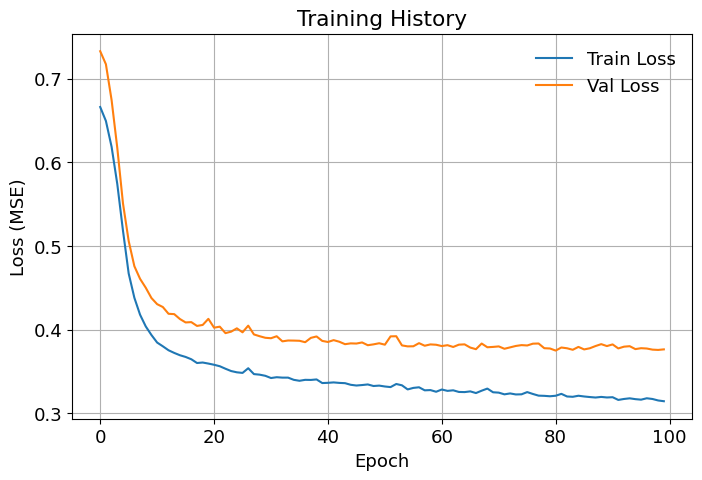

In [27]:
plot_history(train_losses_mae, val_losses_mae)

In [28]:

# 保存训练好的 CO2 通量 CNN 模型的权重的目录
model_path = os.path.join(cwd, "saved_model")
os.makedirs(model_path, exist_ok=True)

In [29]:
# ===== 3.4 保存 CO2 通量 CNN 模型的权重 =====
torch.save(
    model_mse.state_dict(),
    os.path.join(model_path, "cnn_flux_mse_weights.pth")
)
torch.save(
    model_mae.state_dict(),
    os.path.join(model_path, "cnn_flux_mae_weights.pth")
)


### 4. Evaluate the trained model

In [30]:
# 4.1 make new model instances for evaluation (best practice)
model_mse_eval = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)
model_mae_eval = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

# 重新加载我们刚才保存的 CO2 通量模型权重
state_dict_mse = torch.load(
    os.path.join(model_path, "cnn_flux_mse_weights.pth"),
    weights_only=True
)
model_mse_eval.load_state_dict(state_dict_mse)

state_dict_mae = torch.load(
    os.path.join(model_path, "cnn_flux_mae_weights.pth"),
    weights_only=True
)
model_mae_eval.load_state_dict(state_dict_mae)


<All keys matched successfully>

In [31]:
# 4.2 在测试集上做预测，并还原为 (time, lat, lon) 的通量场
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=minibatch_size, shuffle=False
)

# ---- MSE 模型预测 ----
model_mse_eval.to(device).eval()
predictions = []
with torch.no_grad():
    # 注意：我们的 Dataset 里是 (X, y)，这里只用到 X
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mse_eval(batch_X)          # (B, 1, 48, 200)
        predictions.append(outputs.cpu().numpy())

y_test_mse_pre = np.concatenate(predictions, axis=0)   # (N, 1, 48, 200)
y_test_mse_pre = y_test_mse_pre.squeeze(1)             # (N, 48, 200)

# ---- MAE 模型预测 ----
model_mae_eval.to(device).eval()
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mae_eval(batch_X)          # (B, 1, 48, 200)
        predictions.append(outputs.cpu().numpy())

y_test_mae_pre = np.concatenate(predictions, axis=0)   # (N, 1, 48, 200)
y_test_mae_pre = y_test_mae_pre.squeeze(1)             # (N, 48, 200)

# ---- 转成 xarray Dataset 方便后面画图（仍然叫 tas，保持和模板后面代码兼容）----
# flux_ds 的纬度/经度是 lat (48), lon (200)
latitudes  = flux_ds["lat"].values
longitudes = flux_ds["lon"].values

y_test_mse_pre = xr.Dataset(
    coords={
        "time":      time_test,   # 前面划分 train/val/test 时保留的 time_test
        "latitude":  latitudes,
        "longitude": longitudes,
    },
    data_vars=dict(
        tas=(["time", "latitude", "longitude"], y_test_mse_pre)
    ),
)

y_test_mae_pre = xr.Dataset(
    coords={
        "time":      time_test,
        "latitude":  latitudes,
        "longitude": longitudes,
    },
    data_vars=dict(
        tas=(["time", "latitude", "longitude"], y_test_mae_pre)
    ),
)

# ===== 构造真值的 xarray Dataset：y_test_xr =====
y_test_xr = xr.Dataset(
    coords={
        "time":      time_test,
        "latitude":  latitudes,
        "longitude": longitudes,
    },
    data_vars=dict(
        tas=(["time", "latitude", "longitude"], y_test)   # y_test 是真实值
    ),
)

First we check whether the ML model can capture the spatial distribution of CO2 Flux

/tmp/ipykernel_911/1109691940.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_time = y_test_mse_pre.dims["time"]


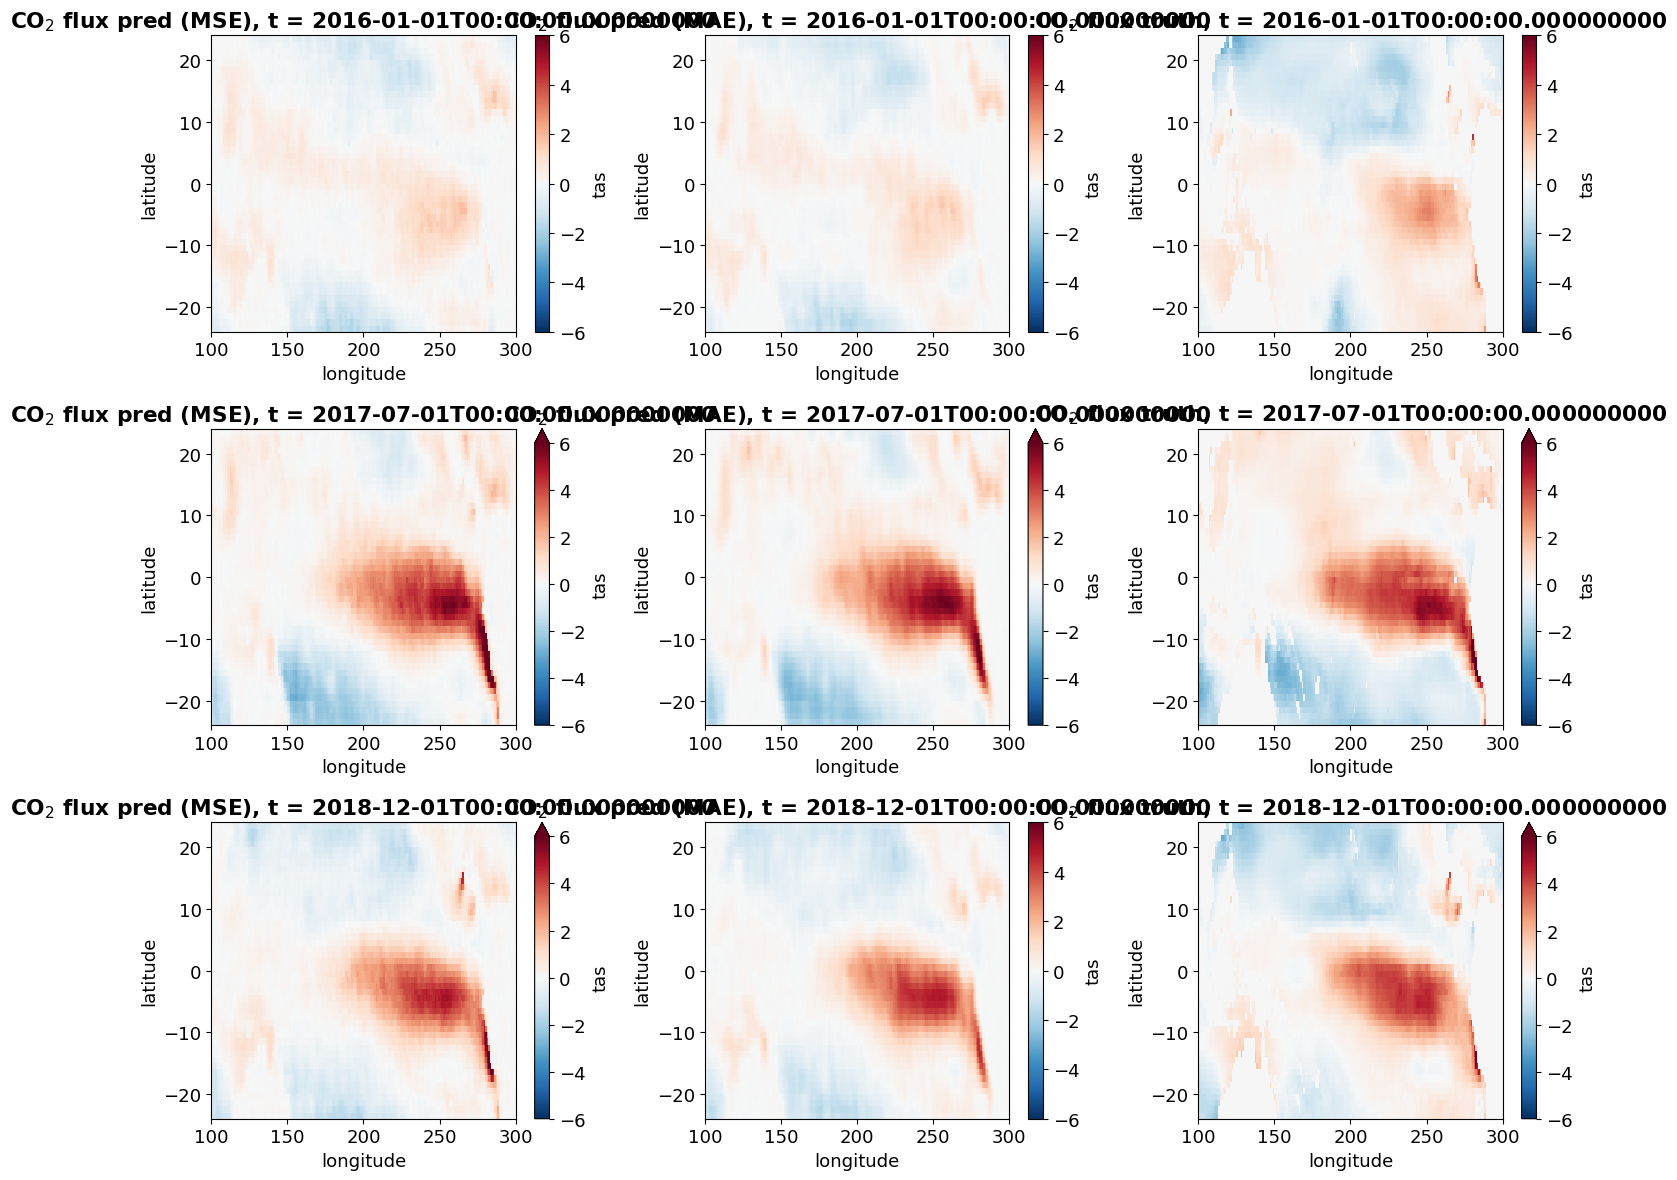

In [32]:
fig, axes = plt.subplots(figsize=(15, 12), ncols=3, nrows=3)

# 选三个代表性的 time 索引：第一条 / 中间 / 最后一条
n_time = y_test_mse_pre.dims["time"]
idxs = [0, n_time // 2, n_time - 1]
times = y_test_mse_pre.time.values[idxs]  # 对应的时间坐标

vmin, vmax = -6, 6
cmap = "RdBu_r"

# 第 1 行：第一个时刻
y_test_mse_pre.tas.isel(time=idxs[0]).plot(
    ax=axes[0, 0], vmin=vmin, vmax=vmax, cmap=cmap
)
y_test_mae_pre.tas.isel(time=idxs[0]).plot(
    ax=axes[0, 1], vmin=vmin, vmax=vmax, cmap=cmap
)
y_test_xr.tas.isel(time=idxs[0]).plot(
    ax=axes[0, 2], vmin=vmin, vmax=vmax, cmap=cmap
)

# 第 2 行：中间时刻
y_test_mse_pre.tas.isel(time=idxs[1]).plot(
    ax=axes[1, 0], vmin=vmin, vmax=vmax, cmap=cmap
)
y_test_mae_pre.tas.isel(time=idxs[1]).plot(
    ax=axes[1, 1], vmin=vmin, vmax=vmax, cmap=cmap
)


y_test_xr.tas.isel(time=idxs[1]).plot(
    ax=axes[1, 2], vmin=vmin, vmax=vmax, cmap=cmap
)

# 第 3 行：最后一个时刻
y_test_mse_pre.tas.isel(time=idxs[2]).plot(
    ax=axes[2, 0], vmin=vmin, vmax=vmax, cmap=cmap
)
y_test_mae_pre.tas.isel(time=idxs[2]).plot(
    ax=axes[2, 1], vmin=vmin, vmax=vmax, cmap=cmap
)
y_test_xr.tas.isel(time=idxs[2]).plot(
    ax=axes[2, 2], vmin=vmin, vmax=vmax, cmap=cmap
)

# 统一设置标题
for i, ax in enumerate(axes.flat):
    row = i // 3
    if i % 3 == 0:
        ax.set_title(f"CO$_2$ flux pred (MSE), t = {times[row]}", fontweight="bold")
    elif i % 3 == 1:
        ax.set_title(f"CO$_2$ flux pred (MAE), t = {times[row]}", fontweight="bold")
    else:
        ax.set_title(f"CO$_2$ flux truth, t = {times[row]}", fontweight="bold")

plt.tight_layout()


Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take Mid Atlantic Ocean as an example (30.0° N, 40.0° W)

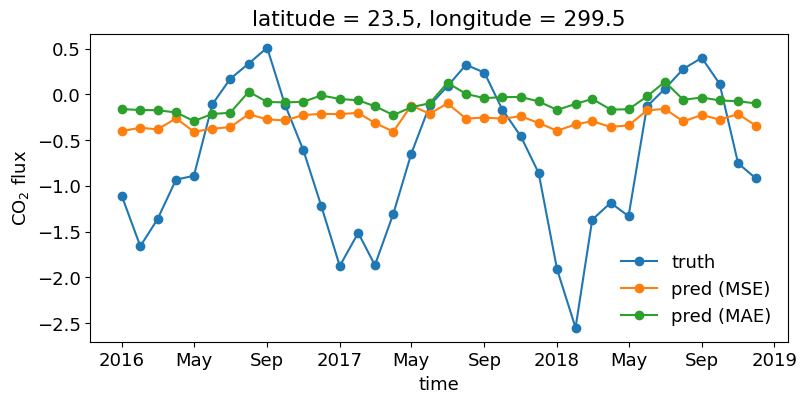

In [33]:
lat = 30.0      # 北大西洋中低纬
lon = -40.0     # 西经 40 度
lon = lon % 360 # 你的数据是 0–360，经度要转一下

fig, ax = plt.subplots(figsize=(9, 4))

y_test_xr.sel(latitude=lat, longitude=lon, method='nearest').tas.plot(
    marker='o', ax=ax, label='truth'
)
y_test_mse_pre.sel(latitude=lat, longitude=lon, method='nearest').tas.plot(
    marker='o', ax=ax, label='pred (MSE)'
)
y_test_mae_pre.sel(latitude=lat, longitude=lon, method='nearest').tas.plot(
    marker='o', ax=ax, label='pred (MAE)'
)

ax.legend()
ax.set_ylabel('CO$_2$ flux')  # 不再写 temperature
plt.show()


Let's check the statistical comparison between truth and prediction.

In [34]:
# ===== 从 xarray 中取出这个海洋点的 time series =====
truth_series = y_test_xr.sel(latitude=lat, longitude=lon, method='nearest').tas.values
mse_series   = y_test_mse_pre.sel(latitude=lat, longitude=lon, method='nearest').tas.values
mae_series   = y_test_mae_pre.sel(latitude=lat, longitude=lon, method='nearest').tas.values

time_series  = y_test_xr.sel(latitude=lat, longitude=lon, method='nearest').tas.time.values

# ===== 组合成 Pandas DataFrame =====
df_ocean_test = pd.DataFrame({
    "time":            time_series,
    "truth_flux":      truth_series,
    "pred_flux_mse":   mse_series,
    "pred_flux_mae":   mae_series,
})

print(df_ocean_test.head(10))

# ===== 统计对比 =====
df_ocean_test.describe()


        time  truth_flux  pred_flux_mse  pred_flux_mae
0 2016-01-01   -1.112565      -0.402545      -0.161662
1 2016-02-01   -1.661182      -0.364431      -0.171430
2 2016-03-01   -1.363275      -0.383987      -0.173974
3 2016-04-01   -0.933119      -0.262148      -0.198021
4 2016-05-01   -0.890290      -0.409226      -0.291989
5 2016-06-01   -0.109089      -0.376125      -0.214480
6 2016-07-01    0.169560      -0.357915      -0.201849
7 2016-08-01    0.336292      -0.217849       0.028151
8 2016-09-01    0.509562      -0.273463      -0.082863
9 2016-10-01   -0.113520      -0.285669      -0.088772


,time,truth_flux,pred_flux_mse,pred_flux_mae
count,36,36.000000,36.000000,36.000000
mean,2017-06-16 10:40:00,-0.680031,-0.280293,-0.091292
min,2016-01-01 00:00:00,-2.551586,-0.409226,-0.291989
25%,2016-09-23 12:00:00,-1.311801,-0.346339,-0.164381
50%,2017-06-16 00:00:00,-0.702453,-0.275011,-0.082011
75%,2018-03-08 18:00:00,0.067518,-0.217569,-0.039963
max,2018-12-01 00:00:00,0.509562,-0.098824,0.137669
std,NaN,0.804887,0.081540,0.091136


Finally we check whether the ML model can capture the time series of CO2 Flux

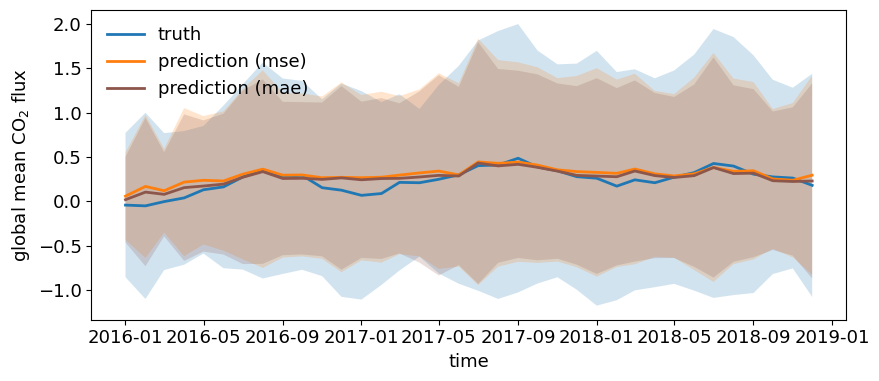

In [35]:
def global_mean_std_plot(X, label, color, ax, var="tas"):
    """
    画出某个字段的经纬加权全球平均时间序列，
    并用 ±1σ 的阴影表示时间上每个点的空间标准差。
    """
    # 以纬度的 cos 作为面积权重
    weights = np.cos(np.deg2rad(X.latitude))

    field_mean = (
        X[var].weighted(weights)
        .mean(["latitude", "longitude"])
        .data
    )
    field_std = (
        X[var].weighted(weights)
        .std(["latitude", "longitude"])
        .data
    )

    t = X.time.data

    ax.plot(t, field_mean, label=label, color=color, linewidth=2)
    ax.fill_between(
        t, field_mean + field_std, field_mean - field_std,
        facecolor=color, alpha=0.2
    )

fig, ax = plt.subplots(figsize=(9, 4))

global_mean_std_plot(y_test_xr,        label="truth",          ax=ax, color="tab:blue")
global_mean_std_plot(y_test_mse_pre,   label="prediction (mse)", ax=ax, color="tab:orange")
global_mean_std_plot(y_test_mae_pre,   label="prediction (mae)", ax=ax, color="tab:brown")

ax.set_xlabel("time")
ax.set_ylabel("global mean CO$_2$ flux")  # 不再写 temperature
ax.legend()
plt.tight_layout()


In [36]:
# 计算某字段的经纬加权全球平均，返回的是 1D time 序列（numpy 数组）
def global_mean(X, var="tas"):
    weights = np.cos(np.deg2rad(X.latitude))
    field_mean = (
        X[var].weighted(weights)
        .mean(["latitude", "longitude"])
        .data
    )
    return field_mean

# 三条时间序列：真值 / MSE 预测 / MAE 预测
gm_truth   = global_mean(y_test_xr)
gm_mse_pre = global_mean(y_test_mse_pre)
gm_mae_pre = global_mean(y_test_mae_pre)

# 直接用 time 轴，而不是通过某个格点 to_dataframe().index 绕一圈
time_series = y_test_xr.time.values

# 放入 DataFrame
df_globalmean_test = pd.DataFrame({
    "time":             time_series,
    "truth_flux":       gm_truth,
    "pred_flux_mse":    gm_mse_pre,
    "pred_flux_mae":    gm_mae_pre,
})

print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()


        time  truth_flux  pred_flux_mse  pred_flux_mae
0 2016-01-01   -0.042128       0.058654       0.018767
1 2016-02-01   -0.050909       0.168748       0.104406
2 2016-03-01   -0.002524       0.119785       0.079343
3 2016-04-01    0.039147       0.217380       0.154986
4 2016-05-01    0.131096       0.237943       0.173129
5 2016-06-01    0.163263       0.230017       0.194558
6 2016-07-01    0.276108       0.306827       0.272000
7 2016-08-01    0.348532       0.363866       0.335500
8 2016-09-01    0.283670       0.295447       0.258124
9 2016-10-01    0.293824       0.298083       0.260480


,time,truth_flux,pred_flux_mse,pred_flux_mae
count,36,36.000000,36.000000,36.000000
mean,2017-06-16 10:40:00,0.236066,0.300602,0.269626
min,2016-01-01 00:00:00,-0.050909,0.058654,0.018767
25%,2016-09-23 12:00:00,0.160971,0.267051,0.240875
50%,2017-06-16 00:00:00,0.261987,0.302729,0.273612
75%,2018-03-08 18:00:00,0.311224,0.342836,0.315057
max,2018-12-01 00:00:00,0.486526,0.445256,0.432212
std,NaN,0.132219,0.081139,0.088493


In [37]:
# 残差 DataArray（保持 time-lat-lon 结构）
res_mse_da = y_test_mse_pre.tas - y_test_xr.tas
res_mae_da = y_test_mae_pre.tas - y_test_xr.tas

# 也可以封装成一个 Dataset，方便保存
residual_ds = xr.Dataset(
    data_vars=dict(
        res_mse=(["time", "latitude", "longitude"], res_mse_da.data),
        res_mae=(["time", "latitude", "longitude"], res_mae_da.data),
    ),
    coords=y_test_xr.coords,
)

# 可选：保存到 NetCDF，后面和别的模型统一读取比较
residual_ds.to_netcdf("cnn_flux_residuals.nc")


getfattr: /home/jovyan/Final: No such file or directory
getfattr: Proj/cnn_flux_residuals.nc: No such file or directory


In [38]:
truth_flat    = y_test_xr.tas.values.ravel()
pred_mse_flat = y_test_mse_pre.tas.values.ravel()
pred_mae_flat = y_test_mae_pre.tas.values.ravel()

def compute_metrics(y_true, y_pred):
    diff = y_pred - y_true
    rmse = float(np.sqrt(np.mean(diff**2)))
    mae  = float(np.mean(np.abs(diff)))
    bias = float(np.mean(diff))
    corr = float(np.corrcoef(y_true, y_pred)[0, 1])

        # R^2
    ss_res = np.sum(diff**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot
    
    return {"RMSE": rmse, "MAE": mae, "Bias": bias, "Corr": corr, "R2": r2}

metrics_cnn_mse = compute_metrics(truth_flat, pred_mse_flat)
metrics_cnn_mae = compute_metrics(truth_flat, pred_mae_flat)

# 汇总成一张表，以后可以把 LSTM、RF 等方法也加进来
df_metrics = pd.DataFrame(
    {
        "CNN_MSE": metrics_cnn_mse,
        "CNN_MAE": metrics_cnn_mae,
        # 以后可以继续加:
        # "LSTM": metrics_lstm,
        # "RandomForest": metrics_rf,
    }
).T

print(df_metrics)
df_metrics.to_csv("cnn_flux_global_metrics.csv")


             RMSE       MAE      Bias      Corr       R2
CNN_MSE  0.602422  0.407360  0.065804  0.861839  0.73928
CNN_MAE  0.603622  0.388346  0.034931  0.861038  0.73824


getfattr: /home/jovyan/Final: No such file or directory
getfattr: Proj/cnn_flux_rmse_bias_maps.nc: No such file or directory


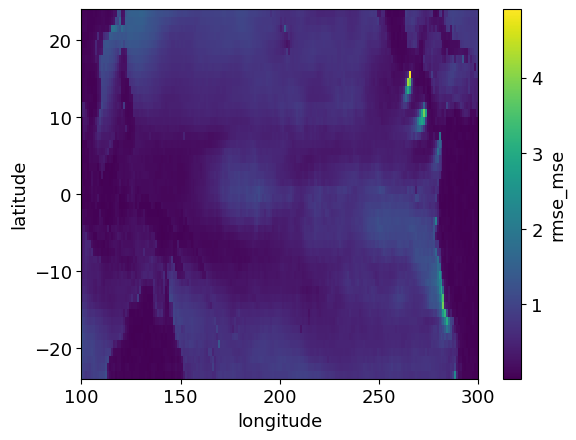

In [39]:
# 时间维上的均方误差 → 再开方 = 按格点的 RMSE
rmse_map_mse = np.sqrt((res_mse_da**2).mean("time"))
rmse_map_mae = np.sqrt((res_mae_da**2).mean("time"))

bias_map_mse = res_mse_da.mean("time")
bias_map_mae = res_mae_da.mean("time")

rmse_bias_ds = xr.Dataset(
    data_vars=dict(
        rmse_mse=(["latitude", "longitude"], rmse_map_mse.data),
        rmse_mae=(["latitude", "longitude"], rmse_map_mae.data),
        bias_mse=(["latitude", "longitude"], bias_map_mse.data),
        bias_mae=(["latitude", "longitude"], bias_map_mae.data),
    ),
    coords={k: v for k, v in y_test_xr.coords.items() if k in ["latitude", "longitude"]},
)

rmse_bias_ds.to_netcdf("cnn_flux_rmse_bias_maps.nc")
rmse_bias_ds.rmse_mse.plot()


### 单变量模型


In [40]:
var_info = {
    0: "dpCO2",
    1: "SST",
    2: "Wind",
}

def train_and_evaluate_single_var(var_idx, var_name):
    """
    训练单个自变量的 CNN 模型，并在 test 集上计算 RMSE / R2。
    这里的输入保持和原始 CNN 一样，是 2D: (N, input_dim)
    只不过单变量时 input_dim = 1。
    var_idx: 0,1,2 分别对应 dpCO2, SST, Wind
    """

    print(f"\n===== Training single-variable model: {var_name} =====")

    # 1) 取出单个变量列，形状 (N, 1)
    X_train_sv = X_train_tensor[:, var_idx:var_idx+1]   # (N_train, 1)
    X_val_sv   = X_val_tensor[:,   var_idx:var_idx+1]   # (N_val,   1)
    X_test_sv  = X_test_tensor[:,  var_idx:var_idx+1]   # (N_test,  1)

    # y 保持不变，还是 (N, 1, 48, 200)
    y_train_sv = y_train_tensor
    y_val_sv   = y_val_tensor
    y_test_sv  = y_test_tensor

    # 2) 构建 Dataset 和 DataLoader
    train_dataset_sv = torch.utils.data.TensorDataset(X_train_sv, y_train_sv)
    val_dataset_sv   = torch.utils.data.TensorDataset(X_val_sv,   y_val_sv)
    test_dataset_sv  = torch.utils.data.TensorDataset(X_test_sv,  y_test_sv)

    train_loader_sv = torch.utils.data.DataLoader(
        train_dataset_sv, batch_size=batch_size, shuffle=True
    )
    val_loader_sv = torch.utils.data.DataLoader(
        val_dataset_sv, batch_size=batch_size, shuffle=False
    )
    test_loader_sv = torch.utils.data.DataLoader(
        test_dataset_sv, batch_size=batch_size, shuffle=False
    )

    # 3) 建立单变量 CNN 模型：input_dim = 1
    input_dim_sv = 1
    model_sv = make_CNN_model(input_dim_sv, n_filters, activation, kernel_size).to(device)

    criterion = mse_loss
    optimizer = torch.optim.Adam(model_sv.parameters(), lr=learning_rate)

    # 4) 训练，返回 loss 曲线
    train_losses_sv, val_losses_sv = pytorch_train(
        model_sv,
        optimizer,
        criterion,
        device,
        train_loader_sv,
        val_loader_sv,
        num_epochs=num_epochs,
        patience=20,
    )

    # 5) 在 test 集上评估
    test_loss, y_true, y_pred = evaluate_model(
        model_sv, criterion, test_loader_sv, device
    )

    # 6) 拉平成一维并转成 numpy，方便 compute_metrics 使用 numpy 计算
    y_true_flat = y_true.reshape(-1).detach().cpu().numpy()
    y_pred_flat = y_pred.reshape(-1).detach().cpu().numpy()

    metrics = compute_metrics(y_true_flat, y_pred_flat)

    print(f"{var_name} single-var model metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.6f}")

    # 返回：评价指标、模型、本变量的训练/验证 loss 曲线
    return metrics, model_sv, train_losses_sv, val_losses_sv




In [41]:
def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    test_loss = 0.0
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)  # 输出 (N, 1, 48, 200)

            loss = criterion(pred, y_batch)
            test_loss += loss.item() * x_batch.size(0)

            y_true_all.append(y_batch.cpu())
            y_pred_all.append(pred.cpu())

    test_loss /= len(data_loader.dataset)

    y_true = torch.cat(y_true_all, dim=0)
    y_pred = torch.cat(y_pred_all, dim=0)

    return test_loss, y_true, y_pred


In [42]:
single_var_results = {}
single_var_models  = {}
single_var_hist    = {}   # 用来存每个单变量的 loss 曲线（如果你想画）

for idx, name in var_info.items():
    # 现在函数返回 4 个值
    metrics, model_sv, train_losses_sv, val_losses_sv = train_and_evaluate_single_var(idx, name)

    single_var_results[name] = metrics
    single_var_models[name]  = model_sv
    single_var_hist[name]    = (train_losses_sv, val_losses_sv)

    # 如果你想顺便画每个单变量模型的训练曲线，可以在这里画
    # plot_history(train_losses_sv, val_losses_sv)


# 把之前「多变量 CNN（全部 3 个通道）」的结果也加进表里
# 假设你前面已经有 metrics_cnn_mse（综合模型的指标字典）
single_var_results["AllVars_CNN"] = metrics_cnn_mse

# 汇总成 DataFrame
df_single_var = pd.DataFrame(single_var_results).T

# 重点看 RMSE 和 R2 两列（也可以顺便看 MAE / Bias / Corr）
print(df_single_var[["RMSE", "R2"]])
df_single_var.to_csv("cnn_flux_single_vs_allvars_metrics.csv")



===== Training single-variable model: dpCO2 =====
Epoch 1/100 | Train Loss: 1.2628 | Val Loss: 1.4579
Epoch 2/100 | Train Loss: 1.2216 | Val Loss: 1.4277
Epoch 3/100 | Train Loss: 1.1818 | Val Loss: 1.3499
Epoch 4/100 | Train Loss: 1.0553 | Val Loss: 1.1432
Epoch 5/100 | Train Loss: 0.8102 | Val Loss: 0.8663
Epoch 6/100 | Train Loss: 0.6362 | Val Loss: 0.7144
Epoch 7/100 | Train Loss: 0.5417 | Val Loss: 0.6192
Epoch 8/100 | Train Loss: 0.4898 | Val Loss: 0.5830
Epoch 9/100 | Train Loss: 0.4606 | Val Loss: 0.5238
Epoch 10/100 | Train Loss: 0.4452 | Val Loss: 0.5026
Epoch 11/100 | Train Loss: 0.4229 | Val Loss: 0.4823
Epoch 12/100 | Train Loss: 0.4111 | Val Loss: 0.4700
Epoch 13/100 | Train Loss: 0.4003 | Val Loss: 0.4658
Epoch 14/100 | Train Loss: 0.3911 | Val Loss: 0.4519
Epoch 15/100 | Train Loss: 0.3814 | Val Loss: 0.4576
Epoch 16/100 | Train Loss: 0.3794 | Val Loss: 0.4377
Epoch 17/100 | Train Loss: 0.3698 | Val Loss: 0.4362
Epoch 18/100 | Train Loss: 0.3692 | Val Loss: 0.4347
Epoc

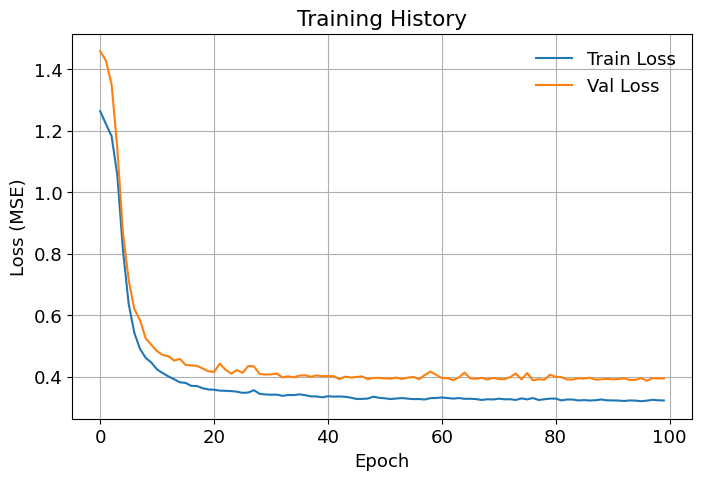

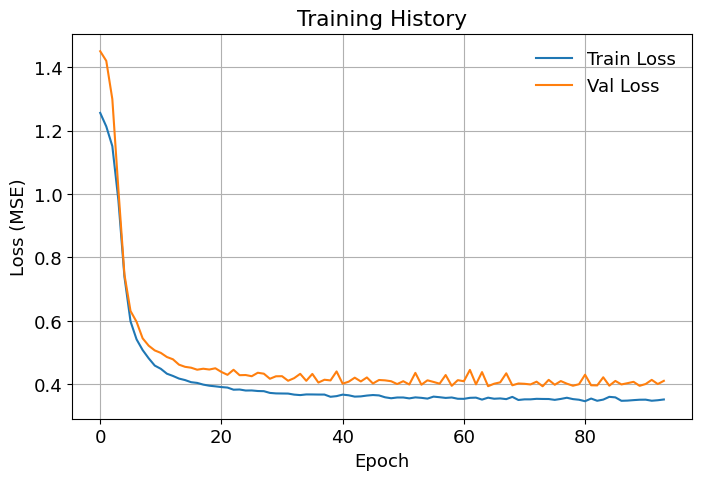

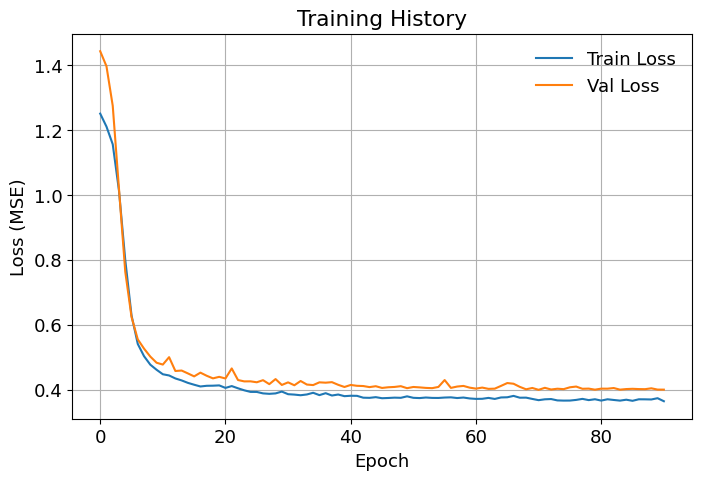

In [43]:
# dpCO2
plot_history(*single_var_hist["dpCO2"])

# SST
plot_history(*single_var_hist["SST"])

# Wind
plot_history(*single_var_hist["Wind"])
